<a href="https://colab.research.google.com/github/sanikha/Anxity-Detection-ML/blob/main/RE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers scikit-learn torch tqdm -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 64.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 46.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 34.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 83.0 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
import seaborn as sns
import matplotlib.pyplot as plt


from transformers import BertTokenizer, BertModel
import torch
from tqdm import tqdm

In [ ]:
import pandas as pd
from google.colab import files

uploaded = files.upload()
df = pd.read_csv("anxiety_tweets.csv")
df.head()

Saving anxiety_tweets.csv to anxiety_tweets.csv


,Timestamp,Username,Tweet
0,2024-09-02 09:01:00.686038,user_0,Feeling really anxious today.
1,2025-01-21 00:28:44.686038,user_1,Panic attacks are the worst.
2,2024-10-28 23:58:14.686038,user_2,I feel like I'm drowning in stress.
3,2024-11-14 00:22:26.686038,user_3,Social anxiety makes everything so hard.
4,2025-03-08 14:56:07.686038,user_4,Does anyone else feel this constant worry?


In [ ]:
df['label'] = df['Tweet'].apply(lambda x: 1 if any(w in x.lower() for w in ['anxious', 'panic', 'stress', 'worried']) else 0)
df[['Tweet', 'label']].head()

,Tweet,label
0,Feeling really anxious today.,1
1,Panic attacks are the worst.,1
2,I feel like I'm drowning in stress.,1
3,Social anxiety makes everything so hard.,0
4,Does anyone else feel this constant worry?,0


In [ ]:
anxiety_keywords = [
    'anxious', 'anxiety', 'panic', 'panic attack', 'nervous',
    'worried', 'worry', 'overthinking', "can't breathe",
    'stressed', 'shaking', 'scared', 'terrified', 'heart racing'
]

df['label'] = df['Tweet'].apply(lambda x: 1 if any(word in x.lower() for word in anxiety_keywords) else 0)


In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
def get_bert_embeddings(text_list):
    embeddings = []
    for text in tqdm(text_list):
        inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=128)
        with torch.no_grad():
            outputs = bert_model(**inputs)
        cls_embedding = outputs.last_hidden_state[0][0].numpy()  # CLS token embedding
        embeddings.append(cls_embedding)
    return np.array(embeddings)

In [ ]:
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['Tweet'], df['label'], test_size=0.2, random_state=42
)

In [ ]:
train_embeddings = get_bert_embeddings(train_texts)
test_embeddings = get_bert_embeddings(test_texts)

100%|██████████| 2000/2000 [03:16<00:00, 10.16it/s]


In [ ]:
svm_model = SVC(kernel='linear', probability=True)
svm_model.fit(train_embeddings, train_labels)


SVC(kernel='linear', probability=True)

In [ ]:
pred_labels = svm_model.predict(test_embeddings)

print("\n📊 Classification Report:\n")
print(classification_report(test_labels, pred_labels))
print("Accuracy:", accuracy_score(test_labels, pred_labels))
print("F1 Score:", f1_score(test_labels, pred_labels))
print("Precision:", precision_score(test_labels, pred_labels))
print("Recall:", recall_score(test_labels, pred_labels))


📊 Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       627
           1       1.00      1.00      1.00      1373

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000

Accuracy: 1.0
F1 Score: 1.0
Precision: 1.0
Recall: 1.0


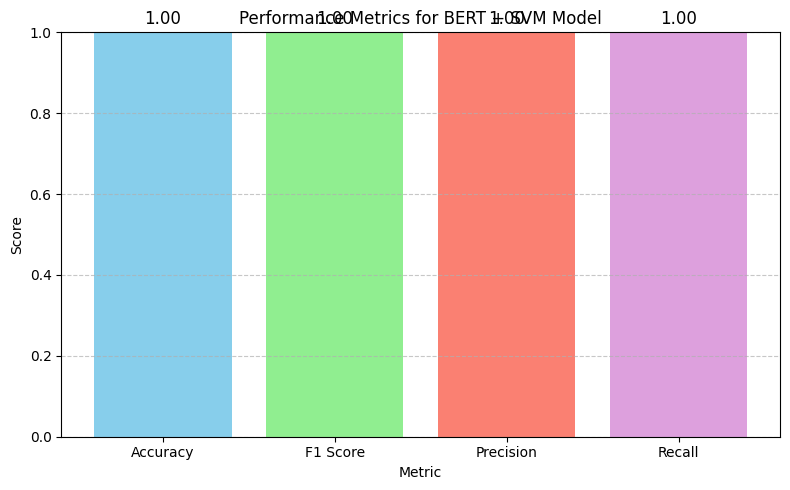

In [ ]:
import matplotlib.pyplot as plt

# Metrics from your model
metrics = {
    'Accuracy': accuracy_score(test_labels, pred_labels),
    'F1 Score': f1_score(test_labels, pred_labels),
    'Precision': precision_score(test_labels, pred_labels),
    'Recall': recall_score(test_labels, pred_labels)
}

# 📈 Plot bar chart
plt.figure(figsize=(8, 5))
plt.bar(metrics.keys(), metrics.values(), color=['skyblue', 'lightgreen', 'salmon', 'plum'])
plt.ylim(0, 1)
plt.title("Performance Metrics for BERT + SVM Model")
plt.ylabel("Score")
plt.xlabel("Metric")
for i, val in enumerate(metrics.values()):
    plt.text(i, val + 0.02, f"{val:.2f}", ha='center', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


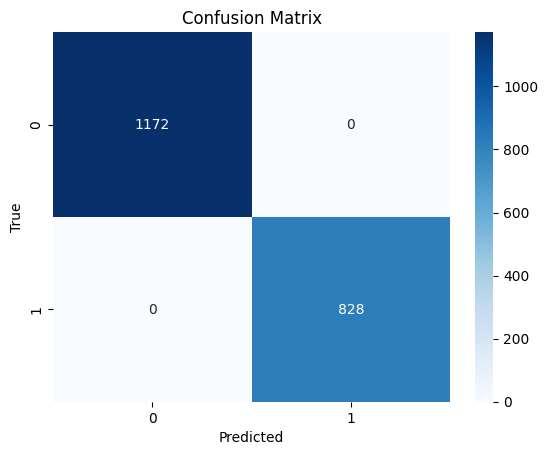

In [ ]:
cm = confusion_matrix(test_labels, pred_labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# 1. Import Libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.svm import SVC
from transformers import BertTokenizer, BertModel
import torch
from tqdm import tqdm
import numpy as np

# 2. Load Dataset
df = pd.read_csv('anxiety_tweets.csv')

# 3. Create Label Column if Not Present
if 'label' not in df.columns:
    df['label'] = df['Tweet'].apply(lambda x: 1 if 'anxious' in x.lower() or 'stress' in x.lower() or 'panic' in x.lower() else 0)

# 4. Split Dataset
train_texts, test_texts, train_labels, test_labels = train_test_split(df['Tweet'], df['label'], test_size=0.2, random_state=42)

# 5. Load BERT Tokenizer and Model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

# 6. Encode Tweets to BERT Embeddings
def get_bert_embeddings(texts):
    embeddings = []
    for text in tqdm(texts, desc="Embedding Tweets"):
        inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=128)
        with torch.no_grad():
            outputs = bert_model(**inputs)
        cls_embedding = outputs.last_hidden_state[:, 0, :].squeeze().numpy()  # [CLS] token
        embeddings.append(cls_embedding)
    return np.array(embeddings)

X_train = get_bert_embeddings(train_texts)
X_test = get_bert_embeddings(test_texts)

# 7. Train SVM Classifier
clf = SVC(kernel='linear', probability=True)
clf.fit(X_train, train_labels)

# 8. Evaluate
pred_labels = clf.predict(X_test)

print("\n--- Evaluation Metrics ---")
print(f"Accuracy: {accuracy_score(test_labels, pred_labels):.4f}")
print(f"F1 Score: {f1_score(test_labels, pred_labels):.4f}")
print(f"Precision: {precision_score(test_labels, pred_labels):.4f}")
print(f"Recall: {recall_score(test_labels, pred_labels):.4f}")

# 9. Prediction Function
def predict_anxiety(tweet):
    inputs = tokenizer(tweet, return_tensors='pt', truncation=True, padding=True, max_length=128)
    with torch.no_grad():
        outputs = bert_model(**inputs)
    cls_embedding = outputs.last_hidden_state[:, 0, :].squeeze().numpy().reshape(1, -1)
    prediction = clf.predict(cls_embedding)[0]
    return "Anxious" if prediction == 1 else "Not Anxious"

# 10. Test the Function
print("\n--- Prediction Examples ---")
print("Tweet: 'I'm feeling nervous and overwhelmed.'")
print("Prediction:", predict_anxiety("I'm feeling nervous and overwhelmed."))

print("Tweet: 'I love peaceful walks in the morning.'")
print("Prediction:", predict_anxiety("I love peaceful walks in the morning."))


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Embedding Tweets: 100%|██████████| 2000/2000 [03:34<00:00,  9.32it/s]



--- Evaluation Metrics ---
Accuracy: 1.0000
F1 Score: 1.0000
Precision: 1.0000
Recall: 1.0000

--- Prediction Examples ---
Tweet: 'I'm feeling nervous and overwhelmed.'
Prediction: Anxious
Tweet: 'I love peaceful walks in the morning.'
Prediction: Anxious
